In [ ]:
!curl https://www.gutenberg.org/files/1661/1661-0.txt -o book.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  593k  100  593k    0     0   751k      0 --:--:-- --:--:-- --:--:--  750k


In [ ]:
text = open('book.txt', 'r', encoding = 'utf-8').read()
text = text.lower()

In [ ]:
sentences = text.split('\n')

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(oov_token = '<UNK>')
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8923

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
input_sequences = []
for sequence in sequences:
    for i in range(len(sequence)):
        n_gram_seq = sequence[:i+1]
        input_sequences.append(n_gram_seq)

In [ ]:
max_seq_len = max(len(seq) for seq in input_sequences)
max_seq_len

20

In [ ]:
padded_seq = pad_sequences(input_sequences, max_seq_len)

In [ ]:
import numpy as np

In [ ]:
padded_seq = np.array(padded_seq)

In [ ]:
x = padded_seq[:,:-1]
y = padded_seq[:,-1]

In [ ]:
x.shape, y.shape

((111152, 19), (111152,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_shape=(max_seq_len-1,)))
model.add(Bidirectional(LSTM(512)))
model.add(Dense(vocab_size, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 19, 100)        │       892,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 1024)           │     2,510,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8923)           │     9,146,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,549,223 (47.87 MB)

 Trainable params: 12,549,223 (47.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

es = EarlyStopping(monitor = 'accuracy', patience=5, min_delta = 0.01,restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='accuracy',factor=0.5, patience=2,verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='accuracy',save_best_only=True,mode='max',verbose=1)

In [ ]:
history = model.fit(x,y,epochs=50,verbose=1,batch_size=1024,callbacks=[es,lr_reducer,checkpoint])

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0539 - loss: 6.9047
Epoch 1: accuracy improved from -inf to 0.07441, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.0541 - loss: 6.9005 - learning_rate: 0.0100
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1248 - loss: 5.5952
Epoch 2: accuracy improved from 0.07441 to 0.12820, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.1248 - loss: 5.5949 - learning_rate: 0.0100
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1586 - loss: 5.0053
Epoch 3: accuracy improved from 0.12820 to 0.15689, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.1585 - loss: 5.0056 - learning_rate: 0.0100
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.1907 - loss: 4.4641
Epoch 4: accuracy improved from 0.15689 to 0.18240, saving model to best_model.keras
109/1

In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

seed_text = 'I could not help laughing at the ease with which he explained his process of deduction.'
next_words = 100

for _ in range(next_words):
    seq = tokenizer.texts_to_sequences([seed_text])[0]
    padded_seq = pad_sequences([seq], maxlen=max_seq_len-1)
    predicted_probs = model.predict(padded_seq, verbose=0)
    predicted_index = np.argmax(predicted_probs)

    output_word = tokenizer.index_word.get(predicted_index, '')
    if output_word == '':
        break

    seed_text += ' ' + output_word

print(seed_text)

I could not help laughing at the ease with which he explained his process of deduction. and i have seen in the way i shall take a cab and go as we may be be a silent and takes the man i have myself leave the wall i see a chinese coin hanging my head and saw a shadow of the room and a landau as i could see a change i at a careful and he was a man with a very deep “g” and above a woman of his time and was a head of a loafer of our friend with a hunting and though he was a of me i thought that i


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'learning_rate'])

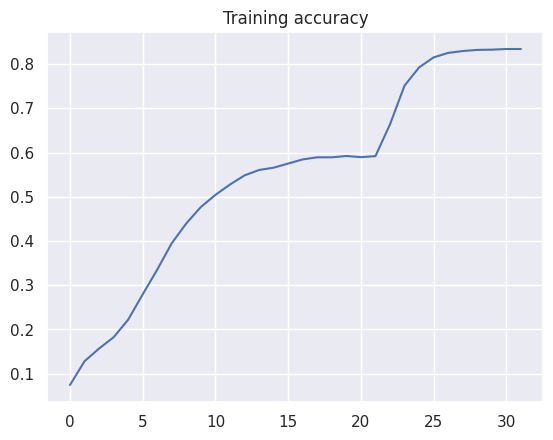

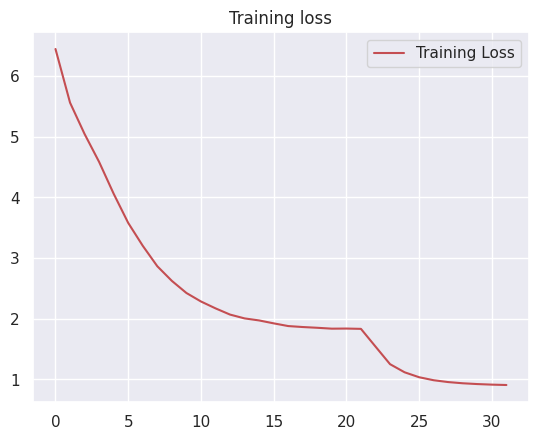

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()